In [1]:
import os
import pickle
import numpy as np

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
import torch

In [3]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
niter = 3
ibatch = 0

# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
# load true continuum
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

# load SpenderQ recon wavelength
w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)

In [26]:
# load model
models, _losses = load_model('/tigress/chhahn/spender_qso/models/london.rebin.iter3.simconloss.0.pt')

losses = []
losses.append(_losses)

for nlat in [6, 8, 12]: 
    _models, _losses = load_model('/tigress/chhahn/spender_qso/models/london.rebin.iter3.simconloss.nlatent%i.pt' % nlat, 
                           latents=nlat)
    models.append(_models[0])
    losses.append(_losses)    

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [35]:
losses[0].shape

(2, 1, 800, 5)

0.3784640593429403
0.380054514142049
0.38073346705377353
0.37886007514661557


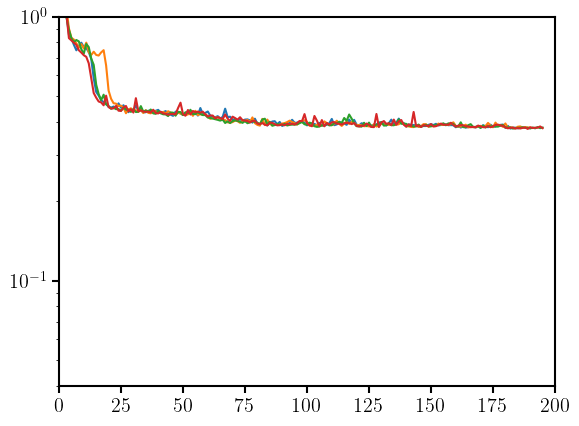

In [43]:
for i in range(4): 
    lim = losses[i][1,:,:,0].flatten() > 0
    plt.plot(np.arange(800)[lim], losses[i][1,:,:,0].flatten()[lim])
    print(losses[i][1,:,:,0].flatten()[lim][-1])
plt.xlim(0, 200)
plt.ylim(None, 1)
plt.yscale('log')

In [10]:
recons = []
for model in models: 
    with torch.no_grad():
        model.eval()

        s = model.encode(spec)
        recon = model.decode(s)
        recons.append(np.array(recon))
recons = np.array(recons)

In [11]:
# select high-z and bright (high normalization) quasars
highzs = np.arange(len(z))[(z > 3.) & (norm > 2.)][:4]

/tmp/ipykernel_2373785/3111015063.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


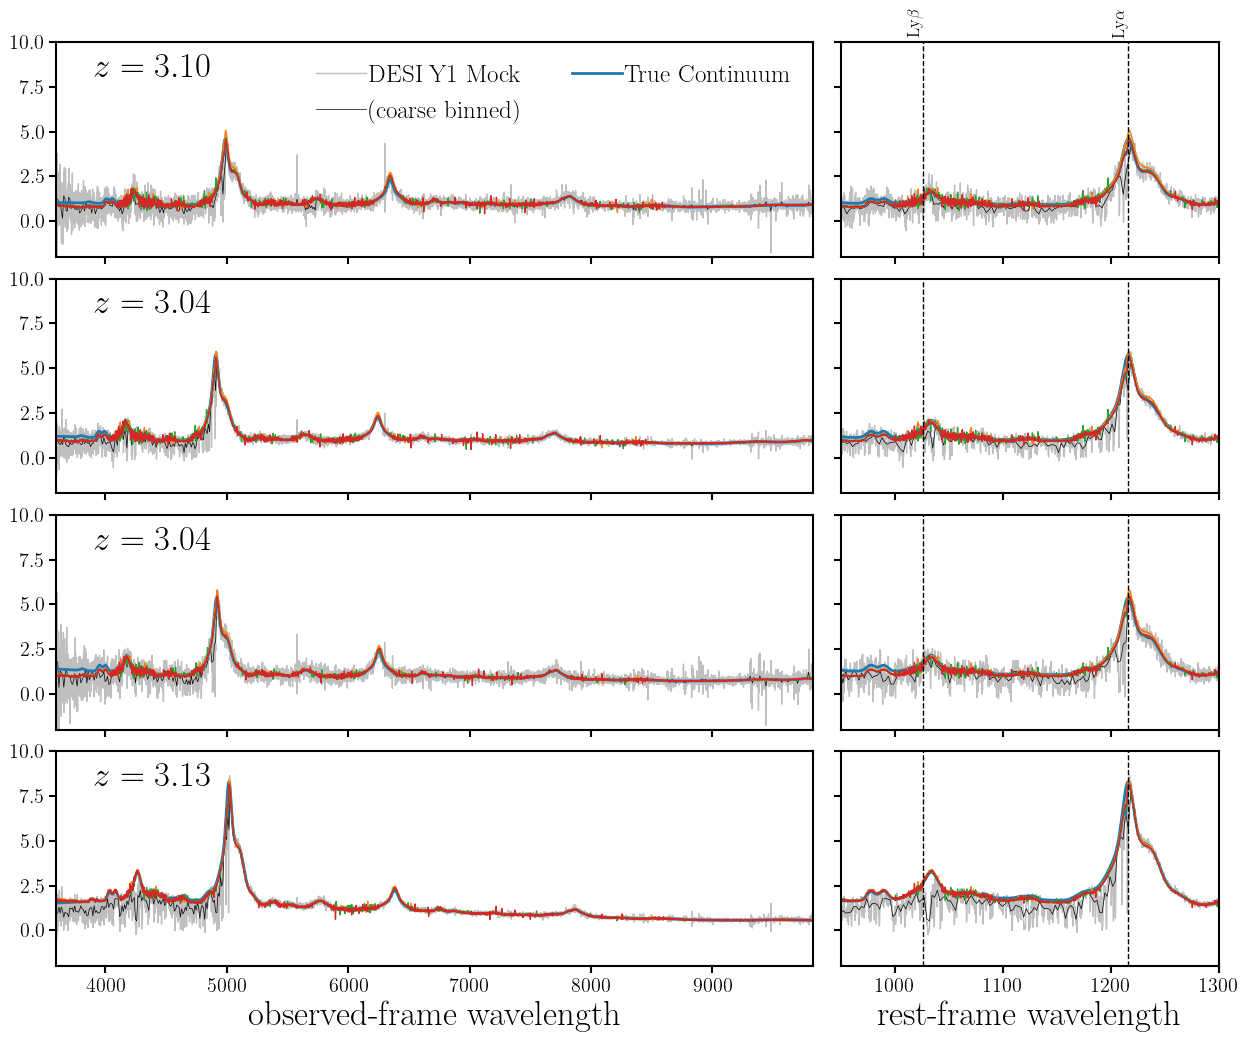

In [12]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(len(highzs), 2, width_ratios=[2, 1]) 

# observed-frame full spectra
wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):
    sub = plt.subplot(gs[2*ii])
    
    # full spectra
    sub.plot(models[0].wave_obs, spec[igal], c='gray', alpha=0.5, lw=1, label='DESI Y1 Mock')
    
    # coarse spectra
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin, spec_rebin, c='k', lw=0.5, label='(coarse binned)')
    
    # true continuum
    sub.plot(np.linspace(3.50e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    
    # spenderq recon
    for _i, recon in enumerate(recons): 
        sub.plot(models[0].wave_rest * (1+z[igal]), recon[igal], color='C%i' % _i, lw=1)
        
    sub.text(0.05, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', ncol=2, fontsize=18, handletextpad=0.1)
    sub.set_ylim(-2, 10.)
sub.set_xlabel("observed-frame wavelength", fontsize=25)

# zoom in rest-frame LyA region 
for ii, igal in enumerate(highzs):
    sub = plt.subplot(gs[2*ii+1])    
    sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.5, lw=1, label='DESI')
    #sub.plot((models[0].wave_obs/(1 + z[igal]))[w[igal] > 0], (spec[igal])[w[igal] > 0], c='gray', alpha=0.5, lw=1)

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=0.5)

    # true continuum
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1+z[igal]), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    
        # spenderq recon
    for _i, recon in enumerate(recons): 
        sub.plot(models[0].wave_rest, recon[igal], color='C%i' % _i, lw=1)
        
    sub.axvline(1026, color='k', linewidth=1, linestyle='--')
    sub.axvline(1216, color='k', linewidth=1, linestyle='--')
    if ii == 0:     
        sub.text(1026, 11.8, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
        sub.text(1216, 11.8, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

    sub.set_xlim(950., 1300.)
    if ii < len(highzs)-1: sub.set_xticklabels([])
    sub.set_ylim(-2, 10.)
    sub.set_yticklabels([])
    
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1, wspace=0.05)
#plt.savefig('spenderq_mock_recon.pdf', bbox_inches='tight')

In [13]:
# continuum residual over full wavelength
wave_rest_rebin = np.linspace(800, 3000, 2000)

dcont_recon, dfcont_recon = [], []

for igal in range(len(z)): 
    wlim = (wave_rest_rebin > 3.6e3/float(1+z[igal])) & ((wave_rest_rebin < 9.9e3/float(1+z[igal])))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    _dcont, _dfcont = [], []
    for recon in recons: 
        # rebin reconstruction
        recon_rebin = U.trapz_rebin(
            w_recon, 
            recon[igal], 
            xnew=wave_rest_rebin[wlim])
    
        # residual
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dcont[wlim] = true_rebin - recon_rebin 
    
        # fractional residual
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont[wlim] = (true_rebin - recon_rebin)/true_rebin
        _dcont.append(dcont)
        _dfcont.append(dfcont)  
        
    dcont_recon.append(np.array(_dcont))
    dfcont_recon.append(np.array(_dfcont))
    
dcont_recon = np.array(dcont_recon)
dfcont_recon = np.array(dfcont_recon)

In [15]:
dfcont_recon.shape

(1024, 4, 2000)

In [16]:
# spenderq performance on QSO with picca 
dcont_q = np.zeros((4, len(wave_rest_rebin), 5))
dfcont_q = np.zeros((4, len(wave_rest_rebin), 5))
for imodel in range(4): 
    for i in np.arange(len(wave_rest_rebin)): 
        has_spectra = (dcont_recon[:,imodel,i] != -999.)

        if np.sum(has_spectra): 
            dcont_q[imodel,i,:] = np.quantile(dcont_recon[:,imodel,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
            dfcont_q[imodel,i,:] = np.quantile(dfcont_recon[:,imodel,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])     

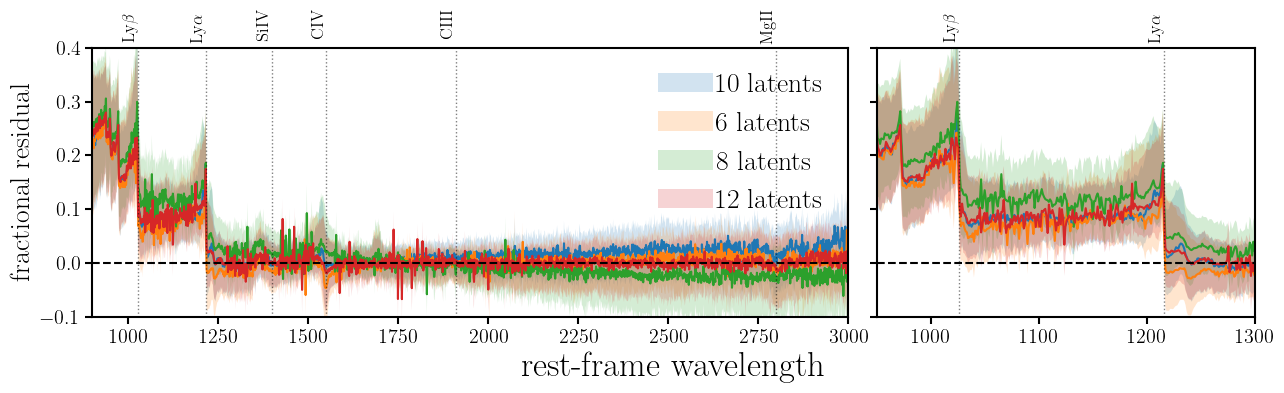

In [18]:
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

# fractional residual
sub = plt.subplot(gs[0])

# SpenderQ
for imodel in range(4): 
    sub.fill_between(wave_rest_rebin, dfcont_q[imodel,:,1], dfcont_q[imodel,:,3], 
                     color='C%i' % imodel, edgecolor='none', alpha=0.2, label='%i latents ' % [10, 6, 8, 12][imodel])
    sub.plot(wave_rest_rebin, dfcont_q[imodel,:,2], color='C%i' % imodel)

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

sub.text(1026, 0.46, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.46, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1397.61, 0.47, r'SiIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1549.48, 0.47, r'CIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1908.73, 0.47, r'CIII', rotation=90., ha='right', va='top', fontsize=12)
sub.text(2799.12, 0.47, r'MgII', rotation=90., ha='right', va='top', fontsize=12)

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlim(900., 3000.)
sub.set_ylabel('fractional residual', fontsize=20)
sub.set_ylim(-0.1, 0.4)

sub = plt.subplot(gs[1])

# SpenderQ
for imodel in range(4): 
    sub.fill_between(wave_rest_rebin, dfcont_q[imodel,:,1], dfcont_q[imodel,:,3], 
                     color='C%i' % imodel, edgecolor='none', alpha=0.2, label='SpenderQ')
    sub.plot(wave_rest_rebin, dfcont_q[imodel,:,2], color='C%i' % imodel)
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.46, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.46, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
sub.set_ylim(-0.1, 0.4)
sub.set_yticklabels([])
fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel('rest-frame wavelength', fontsize=25)

plt.savefig('recon_resid.pdf', bbox_inches='tight')